<a href="https://colab.research.google.com/github/FelipeRuanMarinheiro/Portifolio/blob/main/Regression_Sarimax_IPCA_Econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PREDIÇÃO IPCA SARIMAX - 12 meses

##LIBS

In [8]:
# Importando as bibliotecas necessárias
!pip install pandas matplotlib statsmodels seaborn ruptures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
import ruptures as rpt



##SARIMAX PREDICT

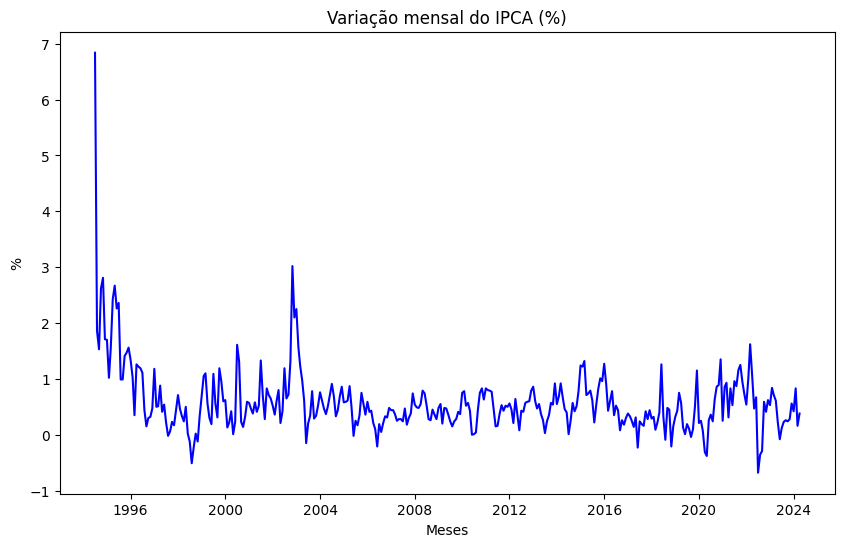

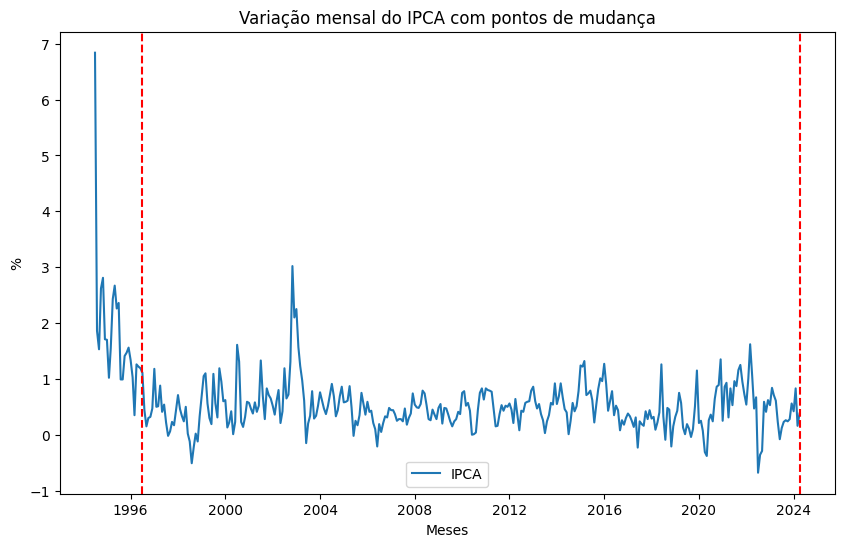

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                               ipca   No. Observations:                  343
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -185.272
Date:                            Wed, 05 Jun 2024   AIC                            380.544
Time:                                    01:48:55   BIC                            399.540
Sample:                                07-01-1994   HQIC                           388.122
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5649      0.071      7.930      0.000       0.425       0.705
ma.L1         -0.8689      0.056   

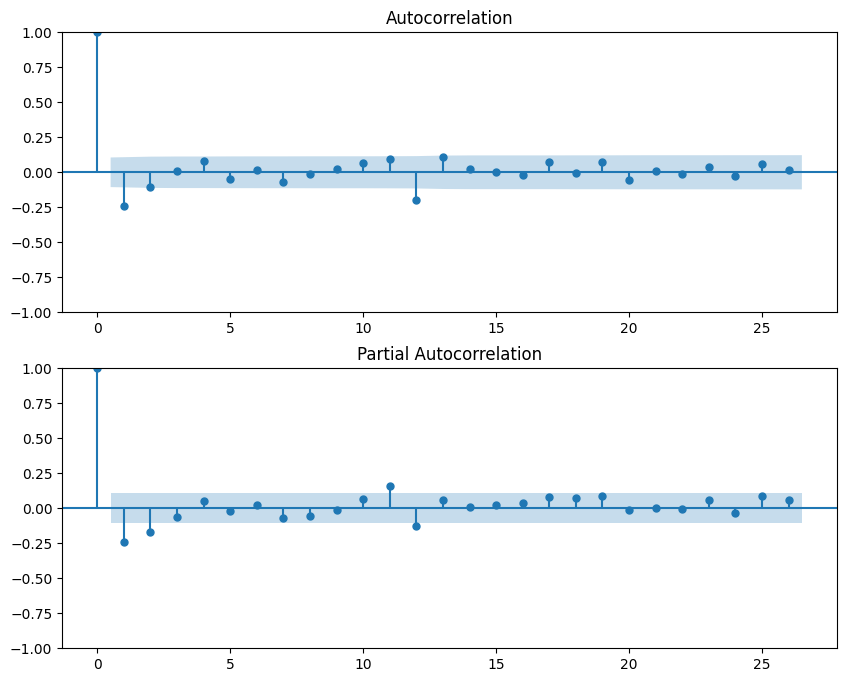

      lb_stat  lb_pvalue
24  58.027802   0.000121
RMSE: 0.26003705315011144
R²: 0.011375652886167043


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


         Data  Valor Real  Previsão 12 meses  Previsão
0  2023-02-01        0.84           0.745220  0.725106
1  2023-03-01        0.71           0.933534  0.971694
2  2023-04-01        0.61           0.538778  0.398766
3  2023-05-01        0.23           0.341447  0.393425
4  2023-06-01       -0.08           0.432140  0.345558
5  2023-07-01        0.12          -0.051447 -0.373384
6  2023-08-01        0.23           0.002259  0.089939
7  2023-09-01        0.26           0.149301  0.292961
8  2023-10-01        0.24           0.574697  0.628395
9  2023-11-01        0.28           0.454308  0.229897
10 2023-12-01        0.56           0.656233  0.521967
11 2024-01-01        0.42           0.411236  0.332448
12 2024-02-01        0.83           0.632376  0.641679
13 2024-03-01        0.16           0.783754  0.781897
14 2024-04-01        0.38           0.426638  0.081637
15 2024-05-01         NaN           0.745220  0.178717
16 2024-06-01         NaN           0.933534  0.101059
17 2024-07

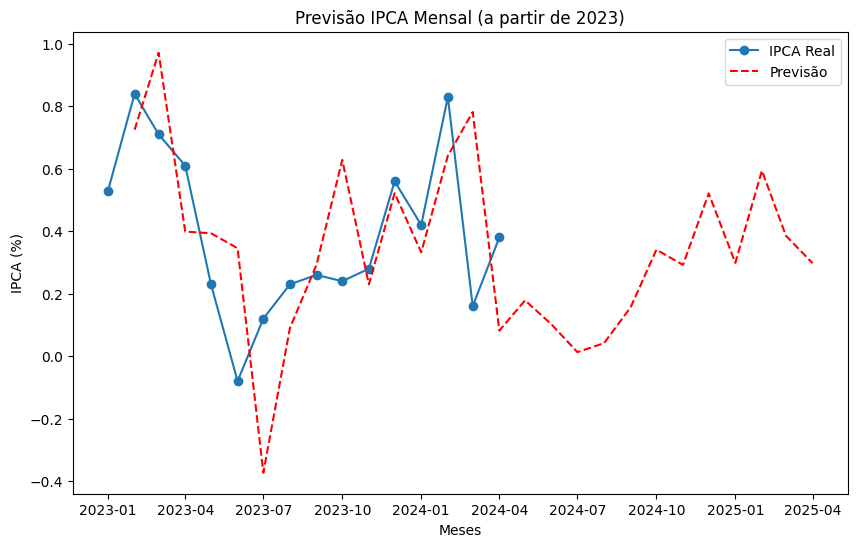

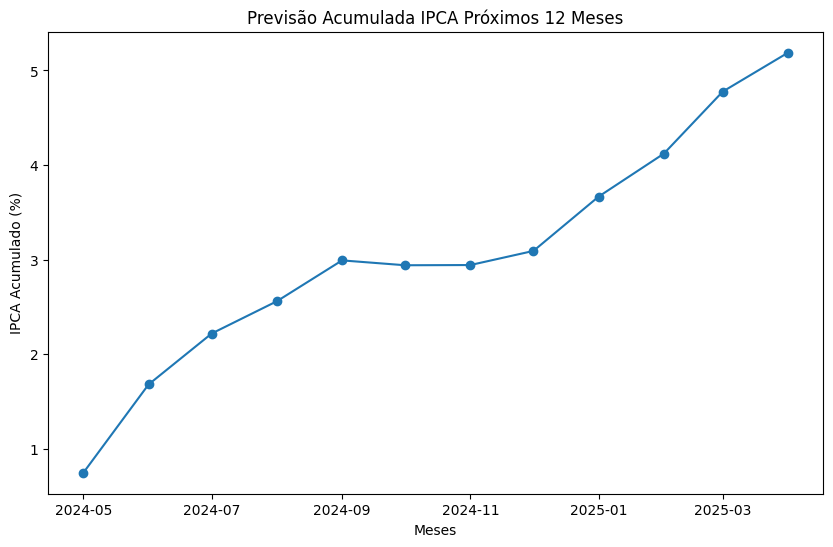

In [20]:
# Carregando os dados
df = pd.read_excel('ipca.xlsx')
df['data'] = pd.to_datetime(df['data'], format='%Y-%m')
df.set_index('data', inplace=True)

# Criando a série temporal
ipca = df['ipca']
ipca.index.freq = 'MS'

# Plotando a série histórica
plt.figure(figsize=(10, 6))
plt.plot(ipca, color='blue', linestyle='-', marker='')
plt.title('Variação mensal do IPCA (%)')
plt.xlabel('Meses')
plt.ylabel('%')
plt.show()

# Detectando pontos de mudança
algo = rpt.Pelt(model="rbf").fit(ipca.values)
result = algo.predict(pen=10)

# Plotando os pontos de mudança
plt.figure(figsize=(10, 6))
plt.plot(ipca, label='IPCA')
for cp in result:
    plt.axvline(ipca.index[cp-1], color='red', linestyle='--')
plt.title('Variação mensal do IPCA com pontos de mudança')
plt.xlabel('Meses')
plt.ylabel('%')
plt.legend()
plt.show()

# Definindo o período de treinamento e teste
train = ipca[:'2023-01-01']
test = ipca['2023-02-01':]

# Ajustando o modelo SARIMA
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_sarima = model.fit(disp=False)
print(fit_sarima.summary())

# Analisando os resíduos
residuals = fit_sarima.resid
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()

# Teste de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[24], return_df=True)
print(lb_test)

# Avaliando a previsão
fcast_fit_sarima = fit_sarima.get_forecast(steps=len(test)).predicted_mean
accuracy = rmse(test, fcast_fit_sarima)
r2 = r2_score(test, fcast_fit_sarima)
print(f'RMSE: {accuracy}')
print(f'R²: {r2}')

# Previsão um passo à frente
fit = SARIMAX(ipca, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_sarima_full = fit.fit(disp=False)
onestep = fit_sarima_full.get_prediction(start='2023-02-01', end='2025-04-01').predicted_mean

# Extensão da previsão para os próximos 12 meses
future_forecast = fit_sarima.get_forecast(steps=12).predicted_mean
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
future_forecast.index = future_dates

# Previsão acumulada dos próximos 12 meses
future_forecast_cumsum = future_forecast.cumsum()

# Concatenando dados reais com previsões
extended_ipca = pd.concat([ipca, future_forecast])

# Tabela com os valores preditos
forecast_table = pd.DataFrame({
    'Data': test.index.append(future_forecast.index),
    'Valor Real': np.append(test.values, [np.nan]*12),
    'Previsão 12 meses': np.append(fcast_fit_sarima.values, future_forecast.values),
    'Previsão': np.append(onestep.loc[test.index].values, onestep.loc[future_forecast.index].values)
})
print(forecast_table)

# Plotando a previsão IPCA mensal iniciando em 2023
plt.figure(figsize=(10, 6))
plt.plot(ipca['2023-01-01':], label='IPCA Real', marker='o')
plt.plot(onestep['2023-01-01':], label='Previsão', color='red', linestyle='--')
plt.title('Previsão IPCA Mensal (a partir de 2023)')
plt.xlabel('Meses')
plt.ylabel('IPCA (%)')
plt.legend()
plt.show()

# Plotando a previsão acumulada iniciando em 2023
plt.figure(figsize=(10, 6))
plt.plot(future_forecast.index, future_forecast_cumsum, marker='o', linestyle='-')
plt.title('Previsão Acumulada IPCA Próximos 12 Meses')
plt.xlabel('Meses')
plt.ylabel('IPCA Acumulado (%)')
plt.show()